# Introduction

Bakker (2016) explores a model that simulates the seawater intrusion of coastal aquifers with the following characteristics: 1) groundwater flow within the aquifer is mostly horizontal 2) the difference in density between freshwater and seawater is less than 2.5 percent 3) the time scale of interest must be less than or equal to 100 years. The water demands of humans and agriculture directly influence groundwater pumping. If groundwater levels decline, seawater intrudes the coastal aquifer system due to a reduction in hydrostatic pressure. As a result of the termination of pumping wells in coastal areas, simulating this process is an important engineering problem.

Most models that solve this problem typically begin with the Darcy equation, which for three-dimensional groundwater flow is written as 

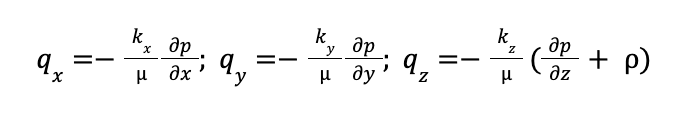
where q, the specific discharge, is split into the x,y, and z directions and k,μ,p, and ⍴ are properties of fluid dynamics: permeability, dynamic viscosity, pressure, and fluid density, respectively (Bakker, 2016; Sherif et al., 2011). The difference between most models is the environment of the aquifer. Some large scale models that simulate seawater intrusion in coastal  aquifers consider the variance of density while others require consideration to the gradient of the flow of the groundwater. In this way, the model Bakker presents is a simple model (Moore & Joye, 2021; Sherif et al., 2011).


# Equations

This paper models the effects of saltwater intrusion on an interface, which is the boundary between saltwater and freshwater, over a time period of 100 years. The model also simulates up to 500 years to show that the interface approaches the steady state condition. We are modeling the position of the interface at a vertical cross section of length 590 meters from a coastline. In this model, there is a coastal aquifer that pumps freshwater (groundwater) while the interface moves as a result of the difference in hydrostatic pressure. As the freshwater flows out of the pump, the interface shifts, adjusting for the pressure difference when compared to the saltwater intrusion into the aquifer on the other side of the interface. Image 1 shows a visual representation from Bakker (1998) of where the saltwater and freshwater are in relation to the interface. According to Bakker (2016), the interface moves to the right (the freshwater side) as the freshwater flows out of the pump. It then moves shorter spatial steps as the time passed increases and the system approaches steady state, as shown in image 2.

We used several parameters detailed below in the code. Since the paper does not specify a parameter for the infiltration of freshwater, N, we assumed it to be zero because it would simplify the equations into the diffusion equation, and there was not a coefficient that matched the dimensions of the other parameters. The paper detailed two equations that are used simultaneously to find the movement of the interface. The first equation describes the flow of water in the cross section (accounting for the presence of an interface), and the second one describes the movement of the interface with respect to the flow.




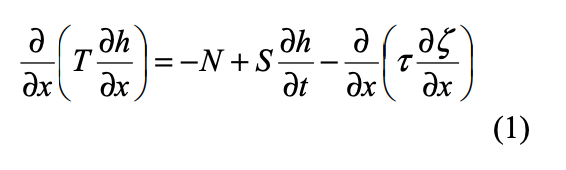

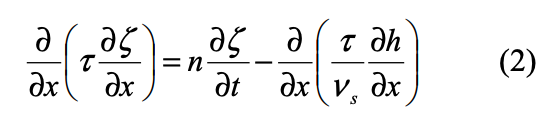

The parameter that we are solving for is the position of the interface during upconing, ζ, which has an initial condition given by the following equation 𝝵0=-Q0kvs.

# Numerical Methods

In [1]:
#EAS 4610 proj
#crank-nicolson method 

# import packages
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import os
import math
from scipy.sparse import spdiags
#import xarray as xr

In [2]:
# PARAMETERS 

k = 2 #m/d   hydraulic conductivity
n = 0.2  #effective porosity
S = 1e-6  #storage coeff
H = 45  #m #thickness of the aquifer
zb = -45 #m #bottom of aquifer
zt = 0 #m #top of aquifer
L = 1000 #m #length of the cross section
W = 1 #m #width of cross-section normal to the plane of flow
vs = 0.025 #dimensionless density
# ditch is located 590 m from the coastline at x = 0
h0 = 0.05 #m
N = 0 #infiltration of freshwater

tau = k*vs*(zt-zb)
T = k*(zt-zb)



# BOUNDARY CONDITIONS

Q0 = 0.1 #m**2/d - outflow, uniform flow towards the coast
Q0p = 0.05 #m**2/d - outflow when water is pumped from the ditch
zeta0 = -Q0/(k*vs) #m - boundary condition at the coast - top 
zeta0p = -Q0p/(k*vs) 
# at x=0, h0 = 0.05 m and zeta0 = -2 m
# at t=0, Q = -0.05 m**2/d
zetaf = -h0/vs  #steady state condition, end of simulation



# DISCRETIZING

x = np.linspace(0,L,L+1)
dx = 10 #m
t = np.linspace(0,36500,500)
dt = 73  #half a year in days

#courant number 
D = 1
CDz = tau*dt/(n*dx**2)
CDh = T*dt/(S*dx**2) #rename to S, currently D as fake storage coeff

#n should be the length of the spatial dimension
#n = len(x)
print(CDz,CDh)

8.2125 65700000.00000001


[[ 0.00000000e+00 -2.06662083e-02  2.57080461e-02 ...  3.12219903e-04
   3.11906277e-04  3.11593595e-04]
 [ 0.00000000e+00  6.28700140e-05  1.56675945e-02 ...  6.24420683e-04
   6.23793489e-04  6.23168181e-04]
 [ 0.00000000e+00  1.47113237e-02  1.36078862e-02 ...  9.36583220e-04
   9.35642573e-04  9.34704755e-04]
 ...
 [ 0.00000000e+00  1.47113237e-02  1.36078862e-02 ...  9.36583220e-04
   9.35642573e-04  9.34704755e-04]
 [ 0.00000000e+00  6.28700140e-05  1.56675945e-02 ...  6.24420683e-04
   6.23793489e-04  6.23168181e-04]
 [ 0.00000000e+00 -2.06662083e-02  2.57080461e-02 ...  3.12219903e-04
   3.11906277e-04  3.11593595e-04]]
[[-2.          0.          0.         ...  0.          0.
   0.        ]
 [-2.          0.82664833 -1.02832184 ... -0.0124888  -0.01247625
  -0.01246374]
 [-2.         -0.0025148  -0.62670378 ... -0.02497683 -0.02495174
  -0.02492673]
 ...
 [-2.         -0.0025148  -0.62670378 ... -0.02497683 -0.02495174
  -0.02492673]
 [-2.          0.82664833 -1.02832184 ... -

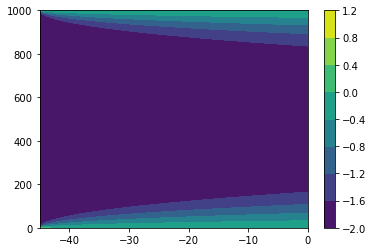

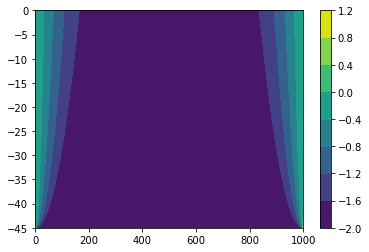

'\nMf2 = np.zeros((len(Mf),3))\nMf2[:,0] = Mf[:,1]\nMf2[:,1] = Mf[:,250]\nMf2[:,2] = Mf[:,-2]\n\nprint(Mf2)\nz = np.linspace(-45,0,3)\nplt.contour(z,x,Mf2)\nplt.colorbar()\n#plt.plot(x,Mf[:,250])\n#plt.plot(x,Mf[:,0])\n#plt.plot(x,Mf[:,-1])\n'

In [3]:
#Making the Matrices/running the model
'''
data1 = np.array([CDh*np.ones(L+1), (1-2*CDh)*np.ones(L+1), CDh*np.ones(L+1)])
diags1 = np.array([-1, 0, 1])
M = spdiags(data1, diags1,L-1,L-1).toarray()

data2 = np.array([CDh*np.ones(L+1), (1-CDh)*np.ones(L+1), CDh*np.ones(L+1)])
diags2 = np.array([-1, 0, 1])
M2 = spdiags(data2, diags2,L-1,L-1).toarray()

data3 = np.array([CDz*np.ones(L+1), (1-2*CDz/vs)*np.ones(L+1), CDz*np.ones(L+1)])
diags3 = np.array([-1, 0, 1])
A = spdiags(data3, diags3,L-1,L-1).toarray()

data4 = np.array([CDz*np.ones(L+1), (1-CDz/vs)*np.ones(L+1), CDz*np.ones(L+1)])
diags4 = np.array([-1, 0, 1])
B = spdiags(data4, diags4,L-1,L-1).toarray()
'''
CD = 2*tau*dt/(n*dx**2)

data3 = np.array([-0.5*CD*np.ones(L+1), (1+CD)*np.ones(L+1), -0.5*CD*np.ones(L+1)])
diags3 = np.array([-1, 0, 1])
A = spdiags(data3, diags3,L-1,L-1).toarray()

data4 = np.array([0.5*CD*np.ones(L+1), (1-CD)*np.ones(L+1), 0.5*CD*np.ones(L+1)])
diags4 = np.array([-1, 0, 1])
B = spdiags(data4, diags4,L-1,L-1).toarray()

#M2[0,:] = 0
#M[0,:] = 0
#M[0,0] = 1

hi1 = np.zeros((L-1,500))
#zetai1 = np.zeros((L-1,500))
zeta = np.zeros((L-1,500))  #given values matrix for zeta
#hmat = np.zeros((L-1,500))  #given values matrix for h


#hmat[0,:] = h0
zeta[:,0] = zeta0
zeta[-1,:] = zetaf


for i in range(0,len(t)-1):
    
    zeta[:,i+1] = np.linalg.inv(A)@(B@zeta[:,i])
    hi1[:,i+1] = zeta[:,i+1]*(-tau/T)

print(hi1)

Mf = np.zeros((L+1,500))   #final matrix
Mf[:,0] = -2
Mf[1:-1] = zeta[0:,:]
Mf[-1,:] = zeta[-1,:]

print(Mf)
'''
print(Mf)
print(hi1) 
print("Zetai1")
print(zetai1)
'''
#print(zeta)

z = np.linspace(-45,0,500)

'''
#print(Mf[0:55])
#plt.contourf(x[0:20],t,np.transpose(Mf[0:20]))

plt.contourf(z,x,Mf)
#plt.ylim(-45,-38)
plt.colorbar()
plt.show()

plt.contourf(x,z,np.transpose(Mf))
plt.colorbar()
plt.show()

for l in range(0,len(Mf)):
    if l%50==0:
        plt.plot((Mf[l,:]),z)
        plt.xlim(-0.01,0.07)
#plt.ylim(0,5)
 #   plt.xlim(0,50)
#    plt.show()
'''
'''
Mf2 = np.zeros((len(Mf),3))
Mf2[:,0] = Mf[:,1]
Mf2[:,1] = Mf[:,250]
Mf2[:,2] = Mf[:,-2]

print(Mf2)
z = np.linspace(-45,0,3)
plt.contour(z,x,Mf2)
plt.colorbar()
#plt.plot(x,Mf[:,250])
#plt.plot(x,Mf[:,0])
#plt.plot(x,Mf[:,-1])
'''

# Results

Forward euler was initially derived for this problem, but with the parameter S=0 from the paper, the last term of the first equation would be undefined (Image 4). To make the method work, we assumed that S was small enough to not affect the solution (10-6); however, spatially and temporally, the numbers rapidly increased toward infinity with Forward Euler and did not reach the steady state of -2 meters. The Crank-Nicholson method gave relatively reasonable results for 𝝵, as the values decreased spatially (columns of 𝝵) to the steady state condition.

Plotting the solution against the z-axis, which ranges from 0 to -45 meters (beneath the surface), gives a solution that shows the movement of the interface as the gallery pumps groundwater from it (Figure 1; Figure 2). As the interface comes closer to the surface at 0 meters, it converges faster to -2 meters, which is indicative of the diffusion of pressure throughout the system, and the orientation of the interface becomes vertical. The plots in the paper also simulated the movement of the interface as a result of the gallery pumping groundwater from the aquifer, which may be the cause of the prominent peaks of the plots. This was not considered in our code, as we simply plotted the movement of the interface. 

Plotting the freshwater head, h, against z gives a graph that shows the movement of the freshwater head (Figure 3). The paper claims that the freshwater head approaches 0.05 meters as freshwater is pumped from the aquifer, and this can be seen in our graph at the end of the simulation at 0 meters. At the start of the simulation, the freshwater head moves quickly as it approaches steady state at 0.05 meters.

A smaller timestep in this model makes the position of the interface converge quickly to -2 meters which is the steady state condition given by 𝝵=-hvs, while a larger timestep makes 𝝵 converge to the steady state condition much slower (Figure 5). To derive Image 2 from the paper, a timestep of 0.5 years was used. In days, which is the unit used throughout the paper, this is the equivalent of 183 days. The difference in convergence to steady state in both graphs is shown in Figure 5, where the x-axis is x and the y-axis is 𝝵.

Similar to Figure 1b in Bakker (2016), splitting the 𝝵 solution matrix between zero and fifty years and fifty and one hundred years gives the plots in Figure 6, where the x-axis is x and the y-axis is 𝝵. 

Without considering various parameters that would affect the model (e.g. variation of density between freshwater and saltwater), the model is relatively simple. The interface moves as groundwater is being pumped from the ground, and the simulation ends before the freshwater head reaches 0 meters and before the interface reaches the surface. This model shows that, without any restrictions, the saltwater will reach the gallery within 100 years. Increasing the complexity of the model will change the rate at which the size of the freshwater head decreases as well as the interface. The model also shows the parameters of interest changing slower as they approach the steady state conditions.

To improve the model, we could include the effect of the gallery, which pumps the groundwater from the aquifer. The paper includes the rate of discharge as a parameter (Q0) to calculate the boundary conditions for 𝝵, but this was not used in our code to show the effect it has on the position of the interface. Adding more parameters to the model would make it more complex, but it would make the model more realistic.


# Figures 

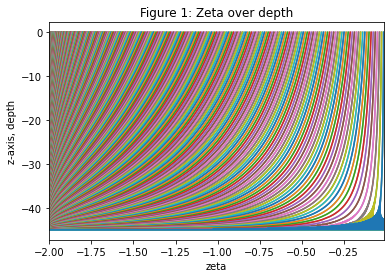

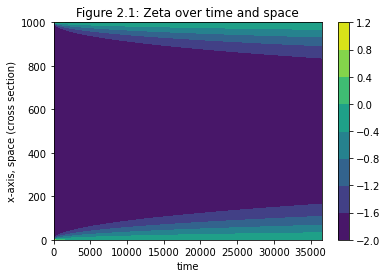

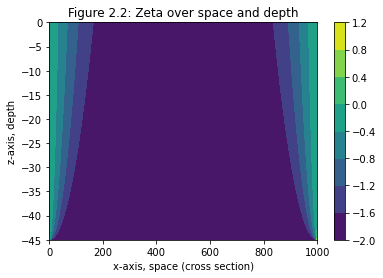

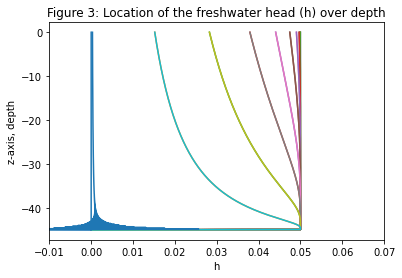

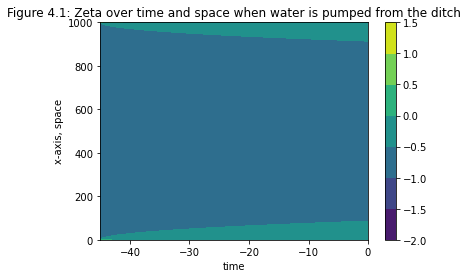

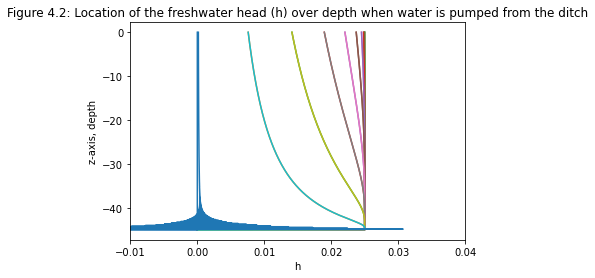

In [8]:

### Figure 1 ### 

for l in range(0,len(Mf)):
    plt.plot((Mf[l,:]),z)
    plt.xlim(-2,-0.01)
    plt.xlabel("zeta")
    plt.ylabel("z-axis, depth")
    plt.title("Figure 1: Zeta over depth")
plt.show()
    
### Figure 2 ###

plt.contourf(t,x,Mf)
plt.xlabel("time")
plt.ylabel("x-axis, space (cross section)")
plt.title("Figure 2.1: Zeta over time and space")
#plt.ylim(-45,-38)
plt.colorbar()
plt.show()


plt.contourf(x,z,np.transpose(Mf))
plt.xlabel("x-axis, space (cross section)")
plt.ylabel("z-axis, depth")
plt.title("Figure 2.2: Zeta over space and depth")
plt.colorbar()
plt.show()


### Figure 3 ###
## Simulation where h is inputed into final matrix instead of zeta ##

Mfh = np.zeros((L+1,500))   #final matrix
Mfh[:,0] = -2
Mfh[1:-1] = hi1[0:,:]
Mfh[-1,:] = hi1[-1,:]

for l in range(0,len(Mfh)):
    if l%50==0:
        plt.plot((Mfh[l,:]),z)
        plt.xlim(-0.01,0.07)
        plt.xlabel("h")
        plt.ylabel("z-axis, depth")
        plt.title("Figure 3: Location of the freshwater head (h) over depth")
plt.show()

### Figure 4 ###
## Simulation of model when water is pumped from the ditch ## 

zetap = np.zeros((L-1,500))  #given values matrix for zeta
hi1p = np.zeros((L-1,500))  #given values matrix for zeta

zetap[:,0] = zeta0p
zetap[-1,:] = zetaf


for i in range(0,len(t)-1):
    
    zetap[:,i+1] = np.linalg.inv(A)@(B@zetap[:,i])
    hi1p[:,i+1] = zetap[:,i+1]*(-tau/T)



Mfp = np.zeros((L+1,500))   #final matrix
Mfp[:,0] = -2
Mfp[1:-1] = zetap[0:,:]
Mfp[-1,:] = zetap[-1,:]


plt.contourf(z,x,Mfp)
plt.xlabel("time")
plt.ylabel("x-axis, space")
plt.title("Figure 4.1: Zeta over time and space when water is pumped from the ditch")
#plt.ylim(-45,-38)
plt.colorbar()
plt.show()



Mfhp = np.zeros((L+1,500))   #final matrix
Mfhp[:,0] = -2
Mfhp[1:-1] = hi1p[0:,:]
Mfhp[-1,:] = hi1p[-1,:]

for l in range(0,len(Mfhp)):
    if l%50==0:
        plt.plot((Mfhp[l,:]),z)
        plt.xlim(-0.01,0.04)
        plt.xlabel("h")
        plt.ylabel("z-axis, depth")
        plt.title("Figure 4.2: Location of the freshwater head (h) over depth when water is pumped from the ditch")
plt.show()

Figure 5: 
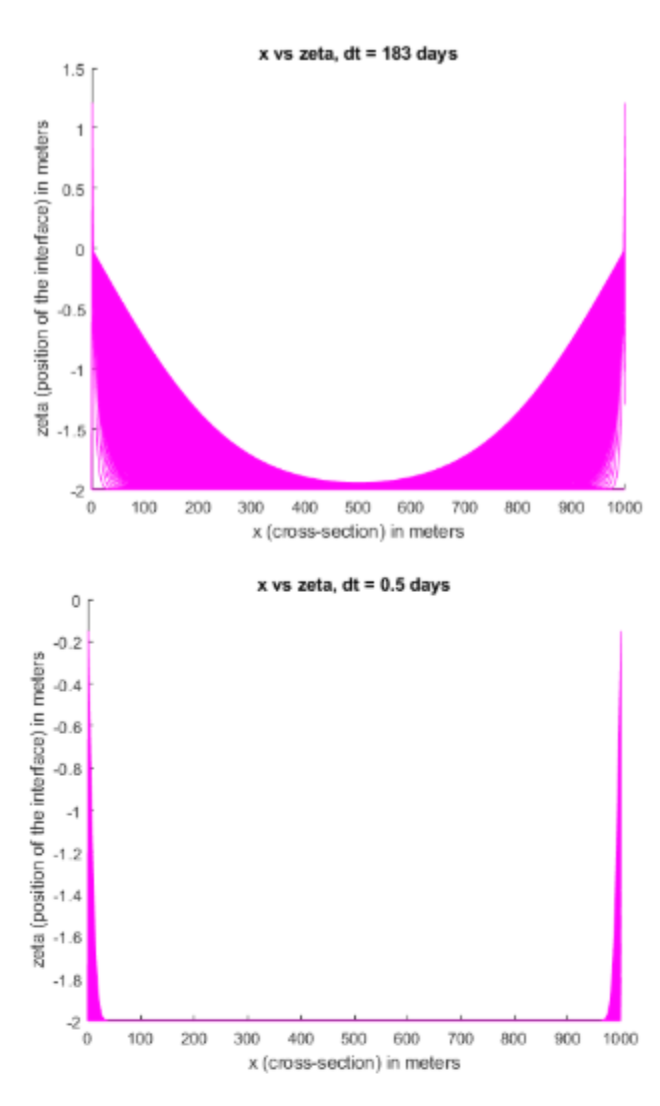

# Video Walkthrough

# Images

Image 1:
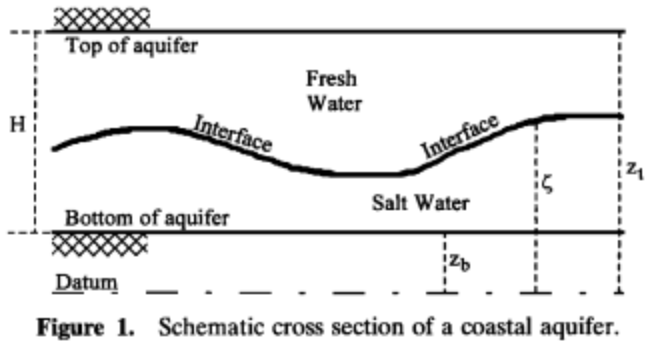

Image 2:

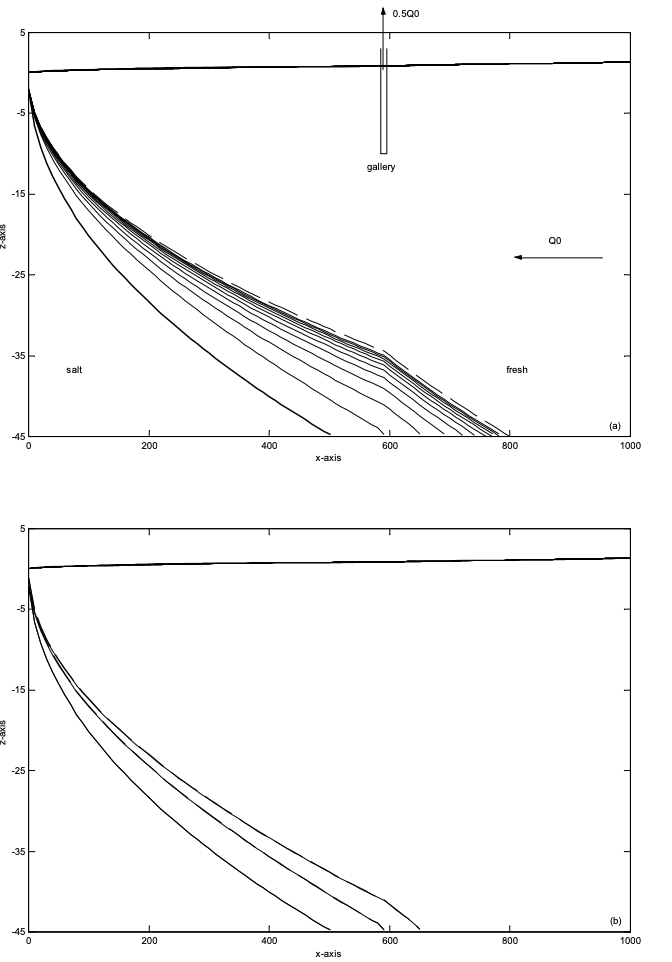


Image 3:
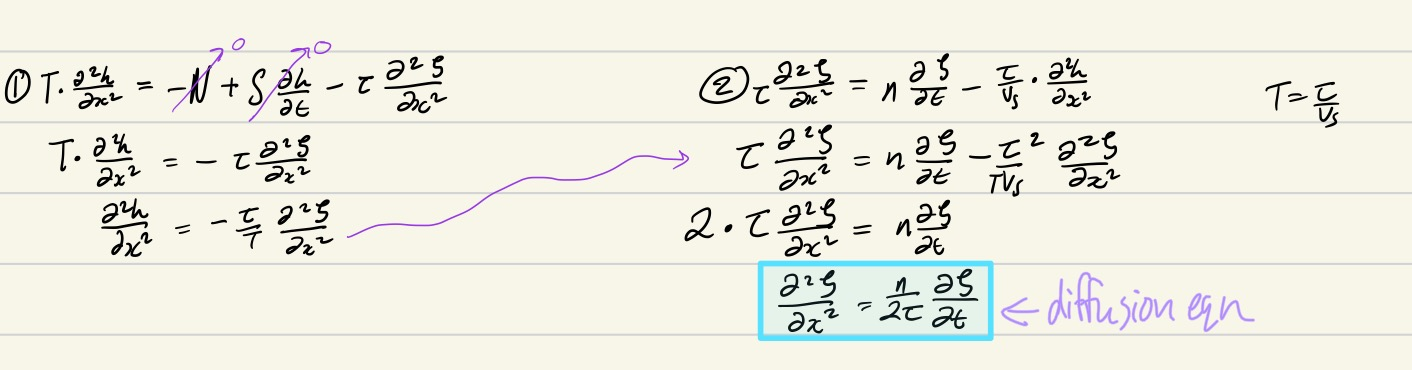

# References
Bakker, M. (1970, January 1). Simple groundwater flow models for seawater intrusion: Semantic scholar. undefined. Retrieved November 27, 2022, from https://www.semanticscholar.org/paper/SIMPLE-GROUNDWATER-FLOW-MODELS-FOR-SEAWATER-Bakker/1ac46ef8707dda37496dd907e3dc9e3b0d52c4bc 

Bakker, M. (1998). Transient dupuit interface flow with partially penetrating features. Water Resources Research, 34(11), 2911–2918. https://doi.org/10.1029/98wr02366 

Moore, W. S., & Joye, S. B. (2021). Saltwater intrusion and submarine groundwater discharge: Acceleration of biogeochemical reactions in changing coastal aquifers. Frontiers in Earth Science, 9. https://doi.org/10.3389/feart.2021.600710 

Sherif, M., Kacimov, A., Javadi, A., & Ebraheem, A. A. (2011). Modeling groundwater flow and seawater intrusion in the coastal aquifer of Wadi Ham, UAE. Water Resources Management, 26(3), 751–774. https://doi.org/10.1007/s11269-011-9943-6 